# Setup

In [2]:
import pandas as pd
import numpy as np
import os

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

plt.style.use('fivethirtyeight')

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 18

plt.rcParams['figure.dpi'] = 400


# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=400):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
# if less than R1K, show as R800 (for eg). If btw R1000 and R999,999, show as R1K or R999K. If R1,000,000 or greater, show as R1M
def currency_formatter(x, pos):
    if x >= 1000000:
        return 'R%1.1fM' % (x * 1e-6)
    elif x < 1000:
        return 'R%1.1d' % (x)
    else:
        return 'R%1.1dK' % (x * 1e-3) 
    
axes_formatter = FuncFormatter(currency_formatter) 

# Download & Process Zomato Data

In [2]:
API_KEY = "0ce0b2e48571f88facd08f8efd3569aa"
ENTITY_TYPE = "city"
SORT_BY = "rating"
SORT_ORDER = ["desc", "asc"]
RAW_FOLDER = "raw/"
PROCESSED_FOLDER = "processed/"

In [3]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [6]:
city_ids = load_data(RAW_FOLDER, "zomato_city_ids")
city_ids.head()

,Country,City,Zomato ID
0,South Africa,Cape Town,64


In [7]:
import requests
import json

def get_categories():
    # Get all zomato categories.
    # Categories are global and not unique to a specific country.
    headers = {"user-key": API_KEY}
    response=requests.get("https://developers.zomato.com/api/v2.1/categories", headers=headers)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    file_name = "categories.json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the category id's for restaurant search function.  
    cat_ids = [category["categories"]["id"] for category in json_data["categories"]]
    return cat_ids
        
def get_establishment_type_for_city(city_id):
    # Finding all establishment types in city_id and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/establishments", 
                          headers=headers, params=params)
    json_data = response.json()
       
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "establishment_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the establishment type id's for restaurant search function.  
    establishment_ids = [establishment["establishment"]["id"] for establishment in json_data["establishments"]]
    return establishment_ids
        
def get_cuisine_type_for_city(city_id):
    # Finding all cuisine types in Cape Town and writing to file
    headers = {"user-key": API_KEY}
    params = {"city_id": city_id}
    response=requests.get("https://developers.zomato.com/api/v2.1/cuisines", 
                          headers=headers, params=params)
    json_data = response.json()
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)    
    file_name = "cuisine_types_" + str(city_id) + "." + "json"
    file_path = os.path.join(RAW_FOLDER, file_name)
    
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)
        
    # return all the cuisine type id's for restaurant search function.
    cuisine_ids = [cuisine["cuisine"]["cuisine_id"] for cuisine in json_data["cuisines"]]
    return cuisine_ids

In [8]:
def download_with_criteria(headers, city_id, file_path, iterable_list, iterable_name, sort_order, is_item_list=False):
    json_dump = []
    
    # if API is not expecting a list for iterable_name, then run through each value as as search criteria
    if not is_item_list:        
        for item in iterable_list:
            start = 0
            results_shown = 20
            while results_shown != 0:                
                params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                          "count": 20, iterable_name: item,"sort": SORT_BY, 
                          "order": sort_order}
                response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                                  headers=headers, params=params)

                json_data = response.json()
                results_shown = int(json_data.get("results_shown", 0))

                if results_shown == 0:
                    break

                # appending each dictionary to a list so that json.load() can process 
                # multiple dictionaries
                json_dump.append(json.dumps(json_data))     

                start += 20
    
    # otherwise pass the full list to iterable_name, such as cuisine's. 
    # note: initially it was attempted to run through the above loop for every cuisine type, but allowed API calls 
    # where exceeded for a single city download attempt. 
    else:
        start = 0
        results_shown = 20
        while results_shown != 0:            
            params = {"entity_id": city_id, "entity_type": ENTITY_TYPE, "start": start, 
                      "count": 20, iterable_name: iterable_list,"sort": SORT_BY, 
                      "order": sort_order}
            response=requests.get("https://developers.zomato.com/api/v2.1/search", 
                              headers=headers, params=params)

            json_data = response.json()
            results_shown = int(json_data.get("results_shown", 0))

            if results_shown == 0:
                break

            # appending each dictionary to a list so that json.load() can process 
            # multiple dictionaries
            json_dump.append(json.dumps(json_data))     

            start += 20
        
            
    
    # each dictionary must exist as a list object for json.load to read it correctly    
    with open(file_path, 'w') as outfile:
        outfile.write("[")
        count = 0
        for item in json_dump:
            outfile.write(item)
            if count < len(json_dump)-1:
                outfile.write(",")
            count += 1
        outfile.write("]")

In [9]:
def get_restaurants(city_id, establishment_types):
     # Find 100 top rated restaurants of each establishment type, category and cuisine type per city and write to file
    headers = {"user-key": API_KEY}
    
    if not os.path.isdir(RAW_FOLDER):
         os.makedirs(RAW_FOLDER)
    
    search_criteria = ["Category", "Establishment Type", "Cuisine Type"]
    city_name = city_ids[city_ids["Zomato ID"] == city_id]["City"].values[0]

    # Download restaurant for city by establishment type
    print("Downloading restaurants for", city_name, "by", search_criteria[1])
    
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_establishment_type_" + str(city_id) + "_" + sort_order + "." + "json"
        file_path = os.path.join(RAW_FOLDER, file_name)
        download_with_criteria(headers, city_id, file_path, establishment_types, "establishment_type", 
                               sort_order, is_item_list=False)
    print("Done")

In [18]:
for city_id in city_ids["Zomato ID"]:
    establishments = get_establishment_type_for_city(city_id)
    get_restaurants(city_id, establishments)

Done


In [10]:
# For each city, we need to combine the restaurant data from the categories-based, establishment type-based and cuisine-based json files. 

def build_csv(city_id, source_type):
    restaurants_list = []
    for sort_order in SORT_ORDER:
        file_name = "restaurants_by_" + source_type + "_" + str(city_id) + "_" + sort_order + ".json"
        source_path = os.path.join(RAW_FOLDER, file_name)

        db = json.load(open(source_path))

        restaurant_cols = ["name", 
                           "cuisines",
                           "aggregate_rating", 
                           "rating_text", 
                           "votes",
                           "currency", 
                           "average_cost_for_two", 
                           "price_range",                    
                           "locality",
                           "locality_verbose",
                           "city", 
                           "zipcode",
                           "country_id",
                           "latitude", 
                           "longitude",                                       
                           "has_online_delivery", 
                           "has_table_booking", 
                           ]

        restaurants = [restaurant_group["restaurant"] for count_group in db 
                           for restaurant_group in count_group["restaurants"]] 

        for restaurant in restaurants:
            restaurant["locality"] = restaurant["location"]["locality"]
            restaurant["locality_verbose"] = restaurant["location"]["locality_verbose"]
            restaurant["city"] = restaurant["location"]["city"]
            restaurant["latitude"] = restaurant["location"]["latitude"]
            restaurant["longitude"] = restaurant["location"]["longitude"]
            restaurant["zipcode"] = restaurant["location"]["zipcode"]
            restaurant["country_id"] = restaurant["location"]["country_id"]
            restaurant["aggregate_rating"] = restaurant["user_rating"]["aggregate_rating"]
            restaurant["votes"] = restaurant["user_rating"]["votes"]
            restaurant["rating_text"] = restaurant["user_rating"]["rating_text"]
            
        restaurants_list.append(restaurants)
        
    df1 = pd.DataFrame(restaurants_list[0], columns=restaurant_cols)
    df2 = pd.DataFrame(restaurants_list[1], columns=restaurant_cols)
    return pd.concat([df1, df2])
    

def process_restaurants_json(city_id):
    
    source_types = ["establishment_type"]
    dfs = []
    for source in source_types:
        dfs.append(build_csv(city_id, source))
    
    if not os.path.isdir(PROCESSED_FOLDER):
         os.makedirs(PROCESSED_FOLDER) 
    
    file_name = "restaurants_" + str(city_id) + ".csv"
    output_path = os.path.join(PROCESSED_FOLDER, file_name)

    data = pd.concat(dfs)
    data.to_csv(output_path, encoding='utf-8-sig', index=False)
    

In [32]:
for city in city_ids["Zomato ID"]:
    process_restaurants_json(city)

# Data Preparation

In [123]:
data = load_data(PROCESSED_FOLDER, 'restaurants_64')
data.shape

(1970, 17)

In [124]:
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,currency,average_cost_for_two,price_range,locality,locality_verbose,city,zipcode,country_id,latitude,longitude,has_online_delivery,has_table_booking
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,R,80,1,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.924108,18.417317,0,0
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,R,40,1,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928691,18.412097,0,0
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,R,165,2,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.919300,18.421512,0,0
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,R,110,2,Newlands,"Newlands, Cape Town",Cape Town,NaN,189,-33.970286,18.461950,0,0
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,R,125,2,Sea Point,"Sea Point, Cape Town",Cape Town,NaN,189,-33.921692,18.382759,0,0


## Remove Duplicates

Since we downloaded the top 100 and bottom 100 restuarants of each category, there is likely to be some duplication as certain categories contain less than 200 restaurants meaning that the same establishment could appear near the bottom of the top 100 or the top of the bottom 100. There are many restaurant franchises in Cape Town, so we'll define a duplicate as a restaurant with the same name at the same locality.

In [125]:
data[data.duplicated(subset=["name", "locality"])]

,name,cuisines,aggregate_rating,rating_text,votes,currency,average_cost_for_two,price_range,locality,locality_verbose,city,zipcode,country_id,latitude,longitude,has_online_delivery,has_table_booking
87,N' Ice,"Ice Cream, Desserts",0.0,Not rated,1,R,70,1,Strand,"Strand, Cape Town",Cape Town,NaN,189,-34.114265,18.822527,0,0
156,Vida E Caffe,"Cafe, Desserts",3.3,Average,17,R,150,2,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.929000,18.411833,0,0
162,Kauai,"Healthy Food, Fast Food",3.3,Average,11,R,200,3,CBD,"CBD, Cape Town",Cape Town,NaN,189,-33.922833,18.420833,0,0
299,The Fat Cactus,"Mexican, Finger Food, Tex-Mex",4.1,Very Good,420,R,300,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928833,18.410833,0,0
301,Rick's Cafe Americain,"Moroccan, Grill, Seafood, Burger, Finger Food",3.9,Good,273,R,320,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.928372,18.410481,0,0
302,Beerhouse on Long,"Grill, German",3.9,Good,305,R,300,4,CBD,"CBD, Cape Town",Cape Town,8001.0,189,-33.925512,18.415936,0,0
303,Bombay Bicycle Club,"Mediterranean, Steak, Finger Food",3.9,Good,279,R,450,4,Gardens,"Gardens, Cape Town",Cape Town,NaN,189,-33.936626,18.404738,0,0
500,Warwick Wine Estate,"South African, Mediterranean, Cafe",4.6,Excellent,104,R,440,4,Stellenbosch,"Stellenbosch, Cape Town",Cape Town,NaN,189,-33.840835,18.864158,0,0
502,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,R,125,2,Sea Point,"Sea Point, Cape Town",Cape Town,NaN,189,-33.921692,18.382759,0,0
503,The Velvet Cake Co.,"Cafe, Desserts, Bakery",4.4,Very Good,130,R,160,2,Bellville,"Bellville, Cape Town",Cape Town,NaN,189,-33.868301,18.641180,0,0


In [126]:
data.duplicated(subset=["name", "locality"]).sum()

614

In [127]:
# duplicates are considerd those restaurants with the same name in the same location. Keep the first instance.
data = data.drop_duplicates(subset=["name", "locality"], keep='first')
data.shape

(1356, 17)

## Removing Unneccessary Columns

In [128]:
#removing currency, country, locality_verbose and zipcode
cols = ['name', 'cuisines', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'locality', 'city',
       'latitude', 'longitude', 'has_online_delivery', 'has_table_booking']
data = data[cols]
data.head()

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,18.417317,0,0
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,18.412097,0,0
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,18.421512,0,0
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,18.461950,0,0
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,18.382759,0,0


## Fix Restaurants with Missing Geographic Info

We'll also identify restaurants that don't have their latitude and longitude specified as we'll be using these parameters during the analysis. Where possible, we'll fill in these values by looking up the restaurant info on Google Maps. If we can't find the info, we'll remove the restaurant from the analysis. 

In [129]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
41,Jessy's Waffles,Desserts,3.2,Average,11,100,2,Gardens,Cape Town,0.0,0.0,0,0
91,DV Café,"Desserts, Cafe, Ice Cream",0.0,Not rated,0,50,1,"Spice Route Farm, Paarl",Cape Town,0.0,0.0,0,0
130,Vida E Caffe,"Cafe, Desserts",3.5,Good,17,150,2,Camps Bay,Cape Town,0.0,0.0,0,0
134,Lekker Vegan,Fast Food,3.4,Average,28,200,3,CBD,Cape Town,0.0,0.0,0,0
361,The Vic Bar,"American, Italian",3.0,Average,6,0,1,Gardens,Cape Town,0.0,0.0,0,0
641,Ben's On the Beach,"Grill, Burger",3.6,Good,58,320,4,Strand,Cape Town,0.0,0.0,0,0
774,La Bella Rosa Bistro & Coffee,"Cafe, Burger, Bakery",2.8,Average,4,160,2,Durbanville,Cape Town,0.0,0.0,0,0
826,The Common Room,Finger Food,0.0,Not rated,0,70,1,CBD,Cape Town,0.0,0.0,0,0
937,Jack Rabbit Mobile Kitchen,"Fast Food, Street Food, South African",0.0,Not rated,3,100,2,Durbanville,Cape Town,0.0,0.0,0,0
1431,Moyo,African,3.4,Average,86,561,4,Newlands,Cape Town,0.0,0.0,0,0


In [130]:
data.loc[41, "latitude"] = -33.9314912; data.loc[41, "longitude"] = 18.416589
data.loc[91, "latitude"] = -33.7643602; data.loc[91, "longitude"] = 18.9180991
data.loc[130, "latitude"] = -33.9511; data.loc[130, "longitude"] = 18.3763713
data.loc[134, "latitude"] = -33.9284282; data.loc[134, "longitude"] = 18.4215289
data.loc[361, "latitude"] = -33.9330936; data.loc[361, "longitude"] = 18.4058024
data.loc[641, "latitude"] = -34.1115314; data.loc[641, "longitude"] = 18.819894
data.loc[774, "latitude"] = -33.833121; data.loc[774, "longitude"] = 18.6438816
data.loc[826, "latitude"] = -33.926449; data.loc[826, "longitude"] = 18.4454532
data.loc[1431, "latitude"] = -33.988727; data.loc[1431, "longitude"] = 18.4313973
data.loc[1540, "latitude"] = -33.9036187; data.loc[1540, "longitude"] = 18.4183216
data.loc[1663, "latitude"] = -33.9358607; data.loc[1663, "longitude"] = 18.8564851

In [131]:
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
937,Jack Rabbit Mobile Kitchen,"Fast Food, Street Food, South African",0.0,Not rated,3,100,2,Durbanville,Cape Town,0.0,0.0,0,0


The only restaurant we couldn't find location information for was Jack Rabbit Mobile Kitchen. This makes sense since it sounds like a food truck that doesn't have a fixed location. We'll remove it.

In [132]:
data = data[(data["longitude"] != 0) & (data["latitude"] != 0)]
data[(data["longitude"] == 0) & (data["latitude"] == 0)]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


We know these are South African restaurants, so all their latitude values should be negative and all their longitude values positive, let's check this.

In [133]:
data[data["latitude"] > 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking
643,The 41,"Contemporary, Seafood, Mediterranean, Sushi",3.5,Good,29,400,4,Camps Bay,Cape Town,33.948688,18.376794,0,0
685,Pearl Mountain,Drinks Only,3.3,Average,7,50,1,"Pearl Mountain Wine Estate, Paarl",Cape Town,33.702186,18.995174,0,0
868,Groot Constantia Winery,Drinks Only,3.9,Good,52,90,1,"Groot Constantia Wine Estate, Constantia",Cape Town,34.026732,18.422542,0,0
1665,Anura Tasting Room,Drinks Only,3.1,Average,5,100,2,Anura,Cape Town,33.804110,18.884110,0,0
1841,The Trading Post Eatery,"Cafe, Deli",3.0,Average,5,200,3,Anura,Cape Town,33.811946,18.885821,0,0


In [134]:
f = lambda x: -x if x > 0 else x
data.latitude = data.latitude.apply(f)
data[data["latitude"] > 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


In [135]:
data[data["longitude"] < 0]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,longitude,has_online_delivery,has_table_booking


## Add Dummy Columns for Each Cuisine Type

We'd like to have a true/false value for each cuisine type. This will make it easier to count restaurants by specific cuisine types later. Zomato piles all the cuisines together in a single comma seperated field, so we need to break this up first and then create dummies.

In [136]:
# Values in cuisine columns may have multiple values with ',' seperator
# Extract each possible cuisine type then ensure each dummy column is prefixed with "cuisine_"

dummies = data['cuisines'].str.get_dummies(sep=", ")
dummies.columns = ["cuisine_" + str(col) for col in dummies.columns]
data = pd.concat([data, dummies], axis=1)
print(data.shape)
data.sample(10)

(1355, 86)


,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Steak,cuisine_Street Food,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese
598,Olami,"Cafe, Middle Eastern, Deli, Mediterranean, Hea...",3.8,Good,45,250,3,CBD,Cape Town,-33.925915,...,0,0,0,0,0,0,0,0,0,0
449,The Restaurant at Clos Malverne,"African, Seafood, Steak",3.9,Good,53,450,4,Stellenbosch,Cape Town,-33.910833,...,1,0,0,0,0,0,0,0,0,0
1105,Steers,Fast Food,2.4,Poor,13,135,2,"Canal Walk Mall, Century City",Cape Town,-33.892667,...,0,0,0,0,0,0,0,0,0,0
84,Milky Lane,Desserts,0.0,Not rated,1,80,1,"N1 City Mall, Goodwood",Cape Town,-33.891864,...,0,0,0,0,0,0,0,0,0,0
1678,Solms Delta Tasting Room,Drinks Only,3.1,Average,10,80,1,Franschhoek,Cape Town,-33.863971,...,0,0,0,0,0,0,0,0,0,0
1603,Newton Johnson Wines,Drinks Only,2.8,Average,7,60,1,Hermanus,Cape Town,-34.367718,...,0,0,0,0,0,0,0,0,0,0
374,The Nameless Pub,Drinks Only,2.9,Average,4,120,2,Somerset West,Cape Town,-34.085738,...,0,0,0,0,0,0,0,0,0,0
895,Cape Point Vineyards,Italian,3.7,Good,55,400,4,Noordhoek,Cape Town,-34.099202,...,0,0,0,0,0,0,0,0,0,0
289,Banana Jam Cafe,"Grill, Burger, Pizza, Caribbean",3.9,Good,243,250,3,"Harfield Village, Claremont",Cape Town,-33.994322,...,0,0,0,0,0,0,0,0,0,0
664,La Parada Del Mar,"Spanish, Tapas",3.4,Average,27,400,4,Camps Bay,Cape Town,-33.950130,...,0,0,0,1,0,0,0,0,0,0


## Extract a Place of Interest from Locality and Store in New Column
Some restaurants are part of a place of interest such as a shopping mall or hotel. This is specified in the locality as a comma-seperated pair. We'll split these out into their own column and use "None" where it doesn't apply. This allows us to investigate rating trends at specific shopping malls, for example.

In [137]:
# Go through each row and extract a place value from the locality if one is specified
# Store the place and locality seperately in order to filter more precisely

places = []
localities = []
def split_locality(row):
    items = row["locality"].split(',')
    if len(items) > 1:
        places.append(items[0])
        localities.append(items[1].strip())
    else:
        places.append("None")
        localities.append(items[0].strip())
        
       
data.apply(split_locality, axis=1)
data["places"] = places
data["locality"] = localities

In [138]:
data[["locality", "places"]].sample(10)

,locality,places
166,Claremont,None
128,Claremont,None
1264,Newlands,None
1538,Franschhoek,None
592,Constantia,None
1408,V & A Waterfront,Victoria Wharf
96,Hout Bay,Bay Habour Market
683,Blouberg,Eden On The Bay Centre
1893,Wellington,None
1097,Rylands,None


## Fix Localities Incorrectly Entered Into Zomato
A number of localities were found with spelling mistakes leading to an incorrect representation of the data. While we could exclude these I would rather try fix them manually so as to keep as much data as possible for the analysis.

In [139]:
mapping = {
    "Dubanville": "Durbanville",
    "Contantia": "Constantia",
    "Tableview": "Table View",
    "Belville":"Bellville",
    "Belvile":"Bellville",
    "Bellvile":"Bellville",
    "V&A Waterfront":"V & A Waterfront",
    "The Woodstock Exchange. Woodstock": "Woodstock",
    "Franschoek":"Franschhoek",
    "Somersetwest":"Somerset West",
    "Kuilsriver":"Kuils River",
    "Greenpoint":"Green Point",
    "Ridgeback Wine Farm": "Paarl",
    "Anura": "Stellenbosch",
    "Hannover": "Hanover Park",
    "NH The Lord Charles Hotel": "Somerset West",
    "Fairbridge Mall": "Brackenfell",
    "Blouberg": "Bloubergstrand",
    "Two Oceans Beach": "Mouille Point",
}

def correct_incorrect_localities(col):
    if col in mapping:
        return mapping.get(col, 'None')
    else:
        return col
    
#data["locality"] = data["locality"].apply(correct_incorrect_localities)

# If no mapping provided, return x
f = lambda x: mapping.get(x, x)
data.locality = data.locality.map(f)

## Build Web Scraper & Add Region Column to Visualise Larger Geographical Areas

In addition to the locality/suburb, we'd like to visualise larger regional trends as well. To do this, we'll scrape a list of Cape Town suburbs and their associated regions from https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs. 

We'll export the suburb/region match to its own data file, then for each restaurant in our dataset, we will match its locality to this list of suburbs and assign the fitting region to a new column in the main dataset.

In [140]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

response = requests.get('https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs')
content = response.content
parser = BeautifulSoup(content, 'html.parser')

#Finding all regions in th Wiki page - these have the .mw-headline class
regions_list = [region.text for region in parser.select(".mw-headline")]
suburbs_by_region = {}                    

# The .wikitable class is assigned to each table of suburbs per region    
regions = parser.select(".wikitable")  

count = 0
for region in regions:
    # Finding each suburb while skipping columns with postal codes
    # Some fields have additional info in (), so splitting on those and removing
    suburbs = [suburb.text.split('(')[0] for suburb in region.select("td")[::3]]
    
    for suburb in suburbs:
        suburbs_by_region[suburb] = regions_list[count]
    count += 1  
 
# We need to manually add entries which are known suburbs of the greater Cape Town area
df = pd.DataFrame(list(suburbs_by_region.items()), columns=['locality', 'region'])
df.to_csv("processed/cape-town-suburbs.csv", encoding='utf-8-sig', index=False)

In [141]:
suburbs = pd.read_csv("processed/cape-town-suburbs.csv")
suburbs.sample(10)

,locality,region
48,Bergvliet,Southern Suburbs
3,Foreshore,City Bowl
43,Imizamo Yethu,Atlantic Seaboard
21,Durbanville,Northern Suburbs
83,Masiphumelele,South Peninsula
27,Kuils River,Northern Suburbs
98,Grassy Park,Cape Flats
94,Bonteheuwel,Cape Flats
25,Kensington,Northern Suburbs
39,Clifton,Atlantic Seaboard


In [142]:
def match_locality(row):
    suburb = suburbs[suburbs['locality'] == row['locality']]
    if suburb.shape[0] == 1:
        return suburb.iloc[0]['region']
    else:
        return "None"

data["region"] = data.apply(match_locality, axis=1)
data.head(10)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,places,region
0,Moro Gelato,"Desserts, Ice Cream",4.8,Excellent,72,80,1,CBD,Cape Town,-33.924108,...,0,0,0,0,0,0,0,0,None,None
1,Unframed Ice Cream,Ice Cream,4.7,Excellent,104,40,1,Gardens,Cape Town,-33.928691,...,0,0,0,0,0,0,0,0,None,City Bowl
2,The Velvet Cake Co.,"Bakery, Desserts",4.6,Excellent,90,165,2,CBD,Cape Town,-33.919300,...,0,0,0,0,0,0,0,0,None,None
3,The Creamery,"Desserts, Ice Cream",4.5,Excellent,389,110,2,Newlands,Cape Town,-33.970286,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
4,My Sugar,"Cafe, Patisserie, Bakery, Desserts",4.5,Excellent,197,125,2,Sea Point,Cape Town,-33.921692,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
5,The Velvet Cake Co.,"Cafe, Desserts, Bakery",4.4,Very Good,130,160,2,Bellville,Cape Town,-33.868301,...,0,0,0,0,0,0,0,0,None,Northern Suburbs
6,The Creamery,"Desserts, Ice Cream",4.2,Very Good,110,110,2,Green Point,Cape Town,-33.904093,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
7,Myog,Desserts,4.1,Very Good,87,100,2,Gardens,Cape Town,-33.931500,...,0,0,0,0,0,0,0,0,None,City Bowl
8,The Creamery,"Desserts, Ice Cream",4.1,Very Good,45,75,1,Claremont,Cape Town,-33.981278,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
9,DV Artisan Chocolate,Desserts,3.9,Good,24,70,1,Paarl,Cape Town,-33.760864,...,0,0,0,0,0,0,0,0,Spice Route Farm,None


In [143]:
# We need to manually add suburbs that are part of the wider Cape Town region including Winelands etc.
# We could exclude these entries from the analysis but we'd then be excluding areas such as Stellenbosch and Franshoek which are know food mecca's in Cape Town.

mapping = {
    "CBD":"City Bowl",
    "Century City":"Northern Suburbs",
    "Paarl":"Winelands",
    "Stellenbosch":"Winelands",
    "V & A Waterfront":"Atlantic Seaboard",
    "Bay Area":"South Peninsula",
    "Franschhoek": "Winelands",
    "Riebeek Kasteel":"West Coast",
    "Gordons Bay":"Helderberg",
    "Hermanus":"Overberg",
    "Robertson":"Winelands",
    "Wellington":"Winelands",
    "Woodstock": "City Bowl",
    "Noordhoek":"South Peninsula",
    "Worcester":"Winelands",
    "Zonnebloem": "City Bowl",
    "Rylands":"Cape Flats",
    "Malmesbury": "West Coast",
    "Darling": "West Coast",
    "Sunningdale":"Northern Suburbs",
    "Cape Town International Airport":"Northern Suburbs",
    "Neelsie Student Centre": "Winelands",
    "Scarborough": "South Peninsula"
}


def map_locality_to_region(row):
    if row['region'] == 'None':
        return mapping.get(row['locality'], 'None')
    else:
        return row['region']
    

data["region"] = data.apply(map_locality_to_region, axis=1)
data[data["region"] == "None"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,places,region
464,Two Oceans Restaurant,Seafood,3.8,Good,54,570,4,Cape Point,Cape Town,-34.356368,...,0,0,0,0,0,0,0,0,None,None


In [144]:
data = data.drop(data.index[data["region"] == "None"].tolist())
data[data["region"] == "None"]

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,places,region


In [145]:
data.sample(50)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,places,region
147,The Izzy Burger,Burger,3.3,Average,28,150,2,Claremont,Cape Town,-33.986599,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
597,Cafe Roux,Cafe,3.8,Good,66,200,3,Noordhoek,Cape Town,-34.097169,...,0,0,0,0,0,0,0,0,None,South Peninsula
225,Jonkershuis Restaurant,"Cape Malay, Cafe",4.2,Very Good,191,350,4,Constantia,Cape Town,-34.030623,...,0,0,0,0,0,0,0,0,Groot Constantia Wine Estate,Southern Suburbs
969,Las Paletas,Ice Cream,3.1,Average,6,40,1,Kenilworth,Cape Town,-34.001490,...,0,0,0,0,0,0,0,0,None,Southern Suburbs
181,Burger King,"Burger, Fast Food",3.2,Average,15,140,2,Parklands,Cape Town,-33.799995,...,0,0,0,0,0,0,0,0,None,West Coast
372,Stones,Drinks Only,2.9,Average,5,150,2,Durbanville,Cape Town,-33.834113,...,0,0,0,0,0,0,0,0,Palm Grove Center,Northern Suburbs
814,Cigar Bar,"African, Seafood, Portuguese",3.0,Average,2,400,4,Hout Bay,Cape Town,-34.047212,...,0,0,0,0,0,0,0,0,Chapmans Peak Beach Hotel,Atlantic Seaboard
569,Baconville,"Cafe, Contemporary",3.8,Good,42,240,3,Bellville,Cape Town,-33.871648,...,0,0,0,0,0,0,0,0,None,Northern Suburbs
115,COOKED,Fast Food,3.6,Good,24,120,2,V & A Waterfront,Cape Town,-33.906982,...,0,0,0,0,0,0,0,0,None,Atlantic Seaboard
1883,Beyerskloof Tasting Room,Drinks Only,3.2,Average,9,50,1,Stellenbosch,Cape Town,-33.891173,...,0,0,0,0,0,0,0,0,Beyerskloof Wine Estate,Winelands


## Add Column to Store The Count of Cuisines Types Offered

In [146]:
def count_cuisines(row):
    count = len([col for col in data.columns if 'cuisine_' in col if row[col] == True])    
    return count

data["cuisine_count"] = data.apply(count_cuisines, axis=1)
data.sample(5)

,name,cuisines,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,locality,city,latitude,...,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,places,region,cuisine_count
507,Honest Chocolate Cafe,"Cafe, Desserts",4.3,Very Good,252,160,2,CBD,Cape Town,-33.922833,...,0,0,0,0,0,0,0,None,City Bowl,2
1858,Barrique,"African, Seafood, Cape Malay, International, M...",3.1,Average,13,400,4,Stellenbosch,Cape Town,-33.960833,...,0,0,0,0,0,0,0,Vredenheim Wine Estate,Winelands,7
32,Gelato Mania,"Desserts, Ice Cream",3.4,Average,20,100,2,Camps Bay,Cape Town,-33.952667,...,0,0,0,0,0,0,0,The Promenade,Atlantic Seaboard,2
675,Aandklas,"Pizza, Beverages",3.4,Average,29,200,3,Stellenbosch,Cape Town,-33.934155,...,0,0,0,0,0,0,0,None,Winelands,2
172,Slice Pizza,Pizza,3.3,Average,18,190,2,CBD,Cape Town,-33.925882,...,0,0,0,0,0,0,0,None,City Bowl,1


In [147]:
data[["cuisines", "cuisine_count"]].sample(10)

,cuisines,cuisine_count
1121,Fast Food,1
1272,"Mexican, Cuban",2
1213,"Japanese, Sushi",2
150,Fast Food,1
75,Desserts,1
296,Asian,1
323,"South African, Grill, Steak, Bar Food, Beverag...",8
803,"Tapas, Beverages, Steak, Burger, Contemporary,...",7
417,"French, Contemporary",2
568,Cafe,1


## Reorder Columns & Export Prepared CSV

In [148]:
col_order = ['name', 'aggregate_rating', 'rating_text', 'votes',
       'average_cost_for_two', 'price_range', 'cuisines', 'cuisine_count', 'places', 'locality', 'region', 'city', 'latitude',
       'longitude', 'has_online_delivery', 'has_table_booking']
other_cols = [c for c in data.columns if c not in col_order]
data = data[col_order+other_cols]
data.sample(5)

,name,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,cuisines,cuisine_count,places,locality,...,cuisine_Steak,cuisine_Street Food,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese
1595,Zevolis,2.6,Average,7,200,3,Drinks Only,1,None,Rondebosch,...,0,0,0,0,0,0,0,0,0,0
1114,Snoekies,2.5,Average,14,140,2,"Fast Food, Seafood",2,None,Sea Point,...,0,0,0,0,0,0,0,0,0,0
1139,Tai Chung,2.6,Average,16,180,2,Chinese,1,None,Athlone,...,0,0,0,0,0,0,0,0,0,0
1265,Captain's Kitchen,2.6,Average,55,280,3,"Seafood, Steak, Pizza, Burger",4,Eden On The Bay Centre,Bloubergstrand,...,1,0,0,0,0,0,0,0,0,0
610,Dalliance,3.9,Good,70,350,4,"Seafood, Tapas",2,Victoria Wharf,V & A Waterfront,...,0,0,0,1,0,0,0,0,0,0


In [149]:
# Order data by rating desc and export to csv
data.sort_values("aggregate_rating", ascending=False, inplace=False).to_csv('processed/zomato-cape-town-final.csv', 
                                                                            encoding='utf-8-sig', index=False)

# Exploratory Data Analysis

Before we look for specific trends we'll give ourselves a better understanding of our dataset. 

In [3]:
data = pd.read_csv('processed/zomato-cape-town-final.csv', encoding='utf-8-sig')
data.head()

,name,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,cuisines,cuisine_count,places,locality,...,cuisine_Steak,cuisine_Street Food,cuisine_Sushi,cuisine_Tapas,cuisine_Tea,cuisine_Tex-Mex,cuisine_Thai,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese
0,The Potluck Club,4.9,Excellent,406,600,4,"European, Contemporary",2,Old Biscuit Mill,Woodstock,...,0,0,0,0,0,0,0,0,0,0
1,La Colombe,4.9,Excellent,146,645,4,"French, Asian",2,None,Constantia,...,0,0,0,0,0,0,0,0,0,0
2,Moro Gelato,4.8,Excellent,72,80,1,"Desserts, Ice Cream",2,None,CBD,...,0,0,0,0,0,0,0,0,0,0
3,Unframed Ice Cream,4.7,Excellent,104,40,1,Ice Cream,1,None,Gardens,...,0,0,0,0,0,0,0,0,0,0
4,The Test Kitchen,4.7,Excellent,242,2800,4,"Continental, European",2,Old Biscuit Mill,Woodstock,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# distribution of values
# count, mean, median of values
# correlation with rating
# count, mean, median by region & suburb. 

# Looking for Trends

In [ ]:
# visualising region and suburb data - bars plots and maps
# 

## Ratings, Cost & Votes by Region and Suburb

In [4]:
df_region = data.pivot_table(index="region")
df_region

,aggregate_rating,average_cost_for_two,cuisine_African,cuisine_American,cuisine_Arabian,cuisine_Asian,cuisine_BBQ,cuisine_Bakery,cuisine_Bar Food,cuisine_Belgian,...,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,cuisine_count,has_online_delivery,has_table_booking,latitude,longitude,price_range,votes
region,,,,,,,,,,,,,,,,,,,,,
Atlantic Seaboard,3.207407,273.814815,0.046296,0.050926,0.000000,0.032407,0.000000,0.078704,0.000000,0.004630,...,0.00463,0.004630,0.000000,2.023148,0,0.013889,-33.926074,18.402206,2.875000,79.282407
Cape Flats,2.375000,163.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,...,0.00000,0.000000,0.000000,2.000000,0,0.000000,-33.972807,18.518291,2.200000,15.150000
City Bowl,3.275458,259.454212,0.043956,0.032967,0.000000,0.018315,0.000000,0.080586,0.000000,0.000000,...,0.00000,0.003663,0.007326,2.032967,0,0.003663,-33.925366,18.421397,2.912088,79.670330
Helderberg,2.942857,238.375000,0.035714,0.017857,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,...,0.00000,0.000000,0.000000,1.928571,0,0.000000,-34.096042,18.854278,2.714286,19.982143
Northern Suburbs,2.804569,205.604061,0.025381,0.015228,0.000000,0.010152,0.000000,0.091371,0.000000,0.000000,...,0.00000,0.000000,0.000000,1.868020,0,0.000000,-33.874771,18.600462,2.578680,30.736041
Overberg,2.814286,272.321429,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,...,0.00000,0.000000,0.000000,1.892857,0,0.000000,-34.372010,19.175354,3.000000,14.000000
South Peninsula,2.786111,218.055556,0.055556,0.055556,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,...,0.00000,0.000000,0.000000,1.750000,0,0.000000,-34.129333,18.427512,2.583333,42.083333
Southern Suburbs,2.966516,229.995475,0.027149,0.018100,0.004525,0.036199,0.004525,0.104072,0.004525,0.000000,...,0.00000,0.000000,0.000000,1.891403,0,0.000000,-33.989874,18.464118,2.656109,51.728507
West Coast,2.894444,206.527778,0.000000,0.027778,0.000000,0.013889,0.000000,0.111111,0.000000,0.013889,...,0.00000,0.000000,0.000000,1.930556,0,0.000000,-33.786038,18.503607,2.638889,36.305556


Text(0.5,0.98,'Rating & Cost for Two by Region')

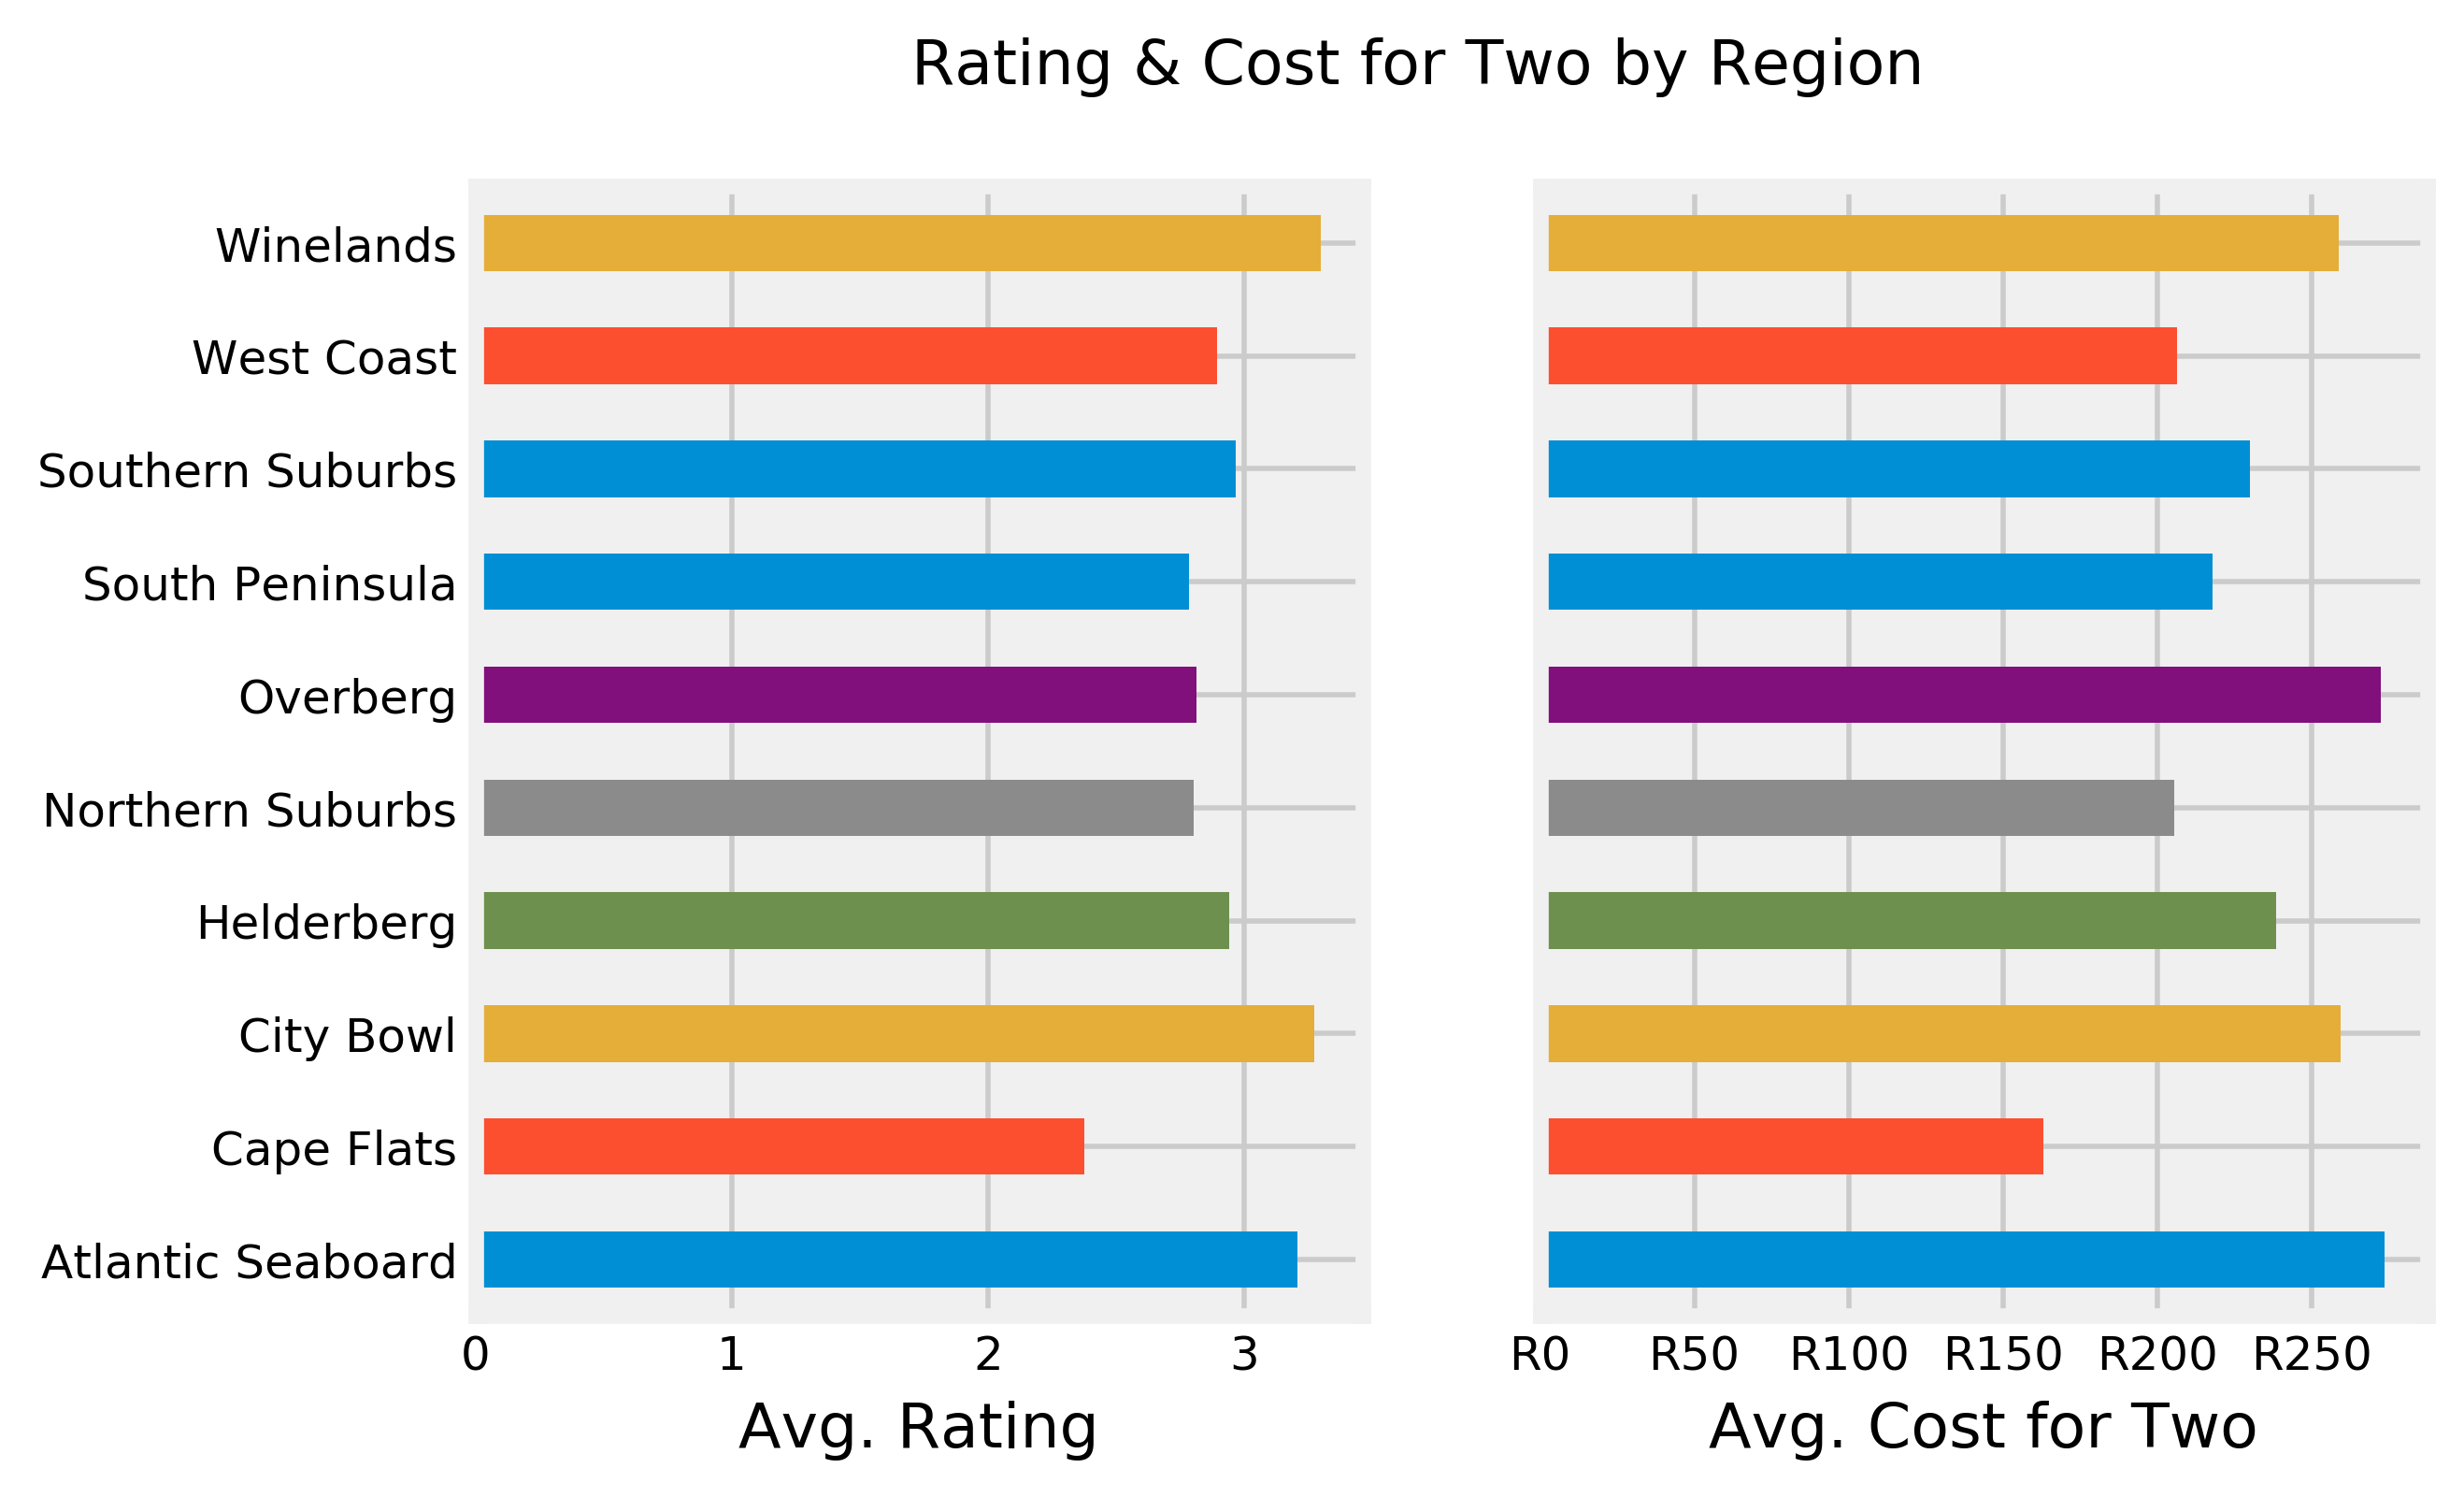

In [5]:
cols = ["aggregate_rating", "average_cost_for_two"]
xlabels = ["Avg. Rating", "Avg. Cost for Two"]
fig, ax = plt.subplots(1, 2, sharey='row', dpi=400)
fig.subplots_adjust(hspace=0.4)

for ax, col, xlabel in zip(ax.ravel(), cols, xlabels):
    df_region[col].plot.barh(ax=ax)
    ax.set_xlabel(xlabel)
    if col == "average_cost_for_two":
        ax.xaxis.set_major_formatter(axes_formatter)
    ax.set_ylabel("")
   
plt.suptitle("Rating & Cost for Two by Region")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

In [14]:
data[data.region == "Overberg"]["locality"].value_counts()

Hermanus    28
Name: locality, dtype: int64

In [7]:
df_suburb = data.pivot_table(index="locality")
df_suburb

,aggregate_rating,average_cost_for_two,cuisine_African,cuisine_American,cuisine_Arabian,cuisine_Asian,cuisine_BBQ,cuisine_Bakery,cuisine_Bar Food,cuisine_Belgian,...,cuisine_Turkish,cuisine_Vegetarian,cuisine_Vietnamese,cuisine_count,has_online_delivery,has_table_booking,latitude,longitude,price_range,votes
locality,,,,,,,,,,,,,,,,,,,,,
Athlone,2.362500,149.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.625000,0,0.000000,-33.963657,18.526069,1.875000,10.375000
Bay Area,3.785714,260.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,2.285714,0,0.000000,-34.128631,18.448696,2.714286,100.714286
Bellville,2.765957,193.936170,0.000000,0.042553,0.000000,0.021277,0.000000,0.127660,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.765957,0,0.000000,-33.876889,18.638439,2.489362,29.361702
Bergvliet,2.066667,156.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.00000,...,0.000000,0.000000,0.000000,4.000000,0,0.000000,-34.050960,18.457438,2.333333,25.666667
Bloubergstrand,3.050000,250.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.00000,...,0.000000,0.000000,0.000000,2.083333,0,0.000000,-33.794926,18.460318,3.166667,50.666667
Brackenfell,2.470000,198.000000,0.100000,0.000000,0.000000,0.050000,0.000000,0.150000,0.000000,0.00000,...,0.000000,0.000000,0.000000,2.200000,0,0.000000,-33.866032,18.692372,2.650000,14.950000
CBD,3.254167,248.381944,0.020833,0.006944,0.000000,0.020833,0.000000,0.062500,0.000000,0.00000,...,0.000000,0.000000,0.006944,1.909722,0,0.000000,-33.923934,18.418470,2.937500,79.701389
Camps Bay,3.468421,412.368421,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,2.368421,0,0.000000,-33.956864,18.375004,3.421053,60.578947
Cape Town International Airport,2.414286,259.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,2.571429,0,0.000000,-33.970056,18.598032,3.000000,22.857143


Text(0.5,0.98,'Rating by Suburb')

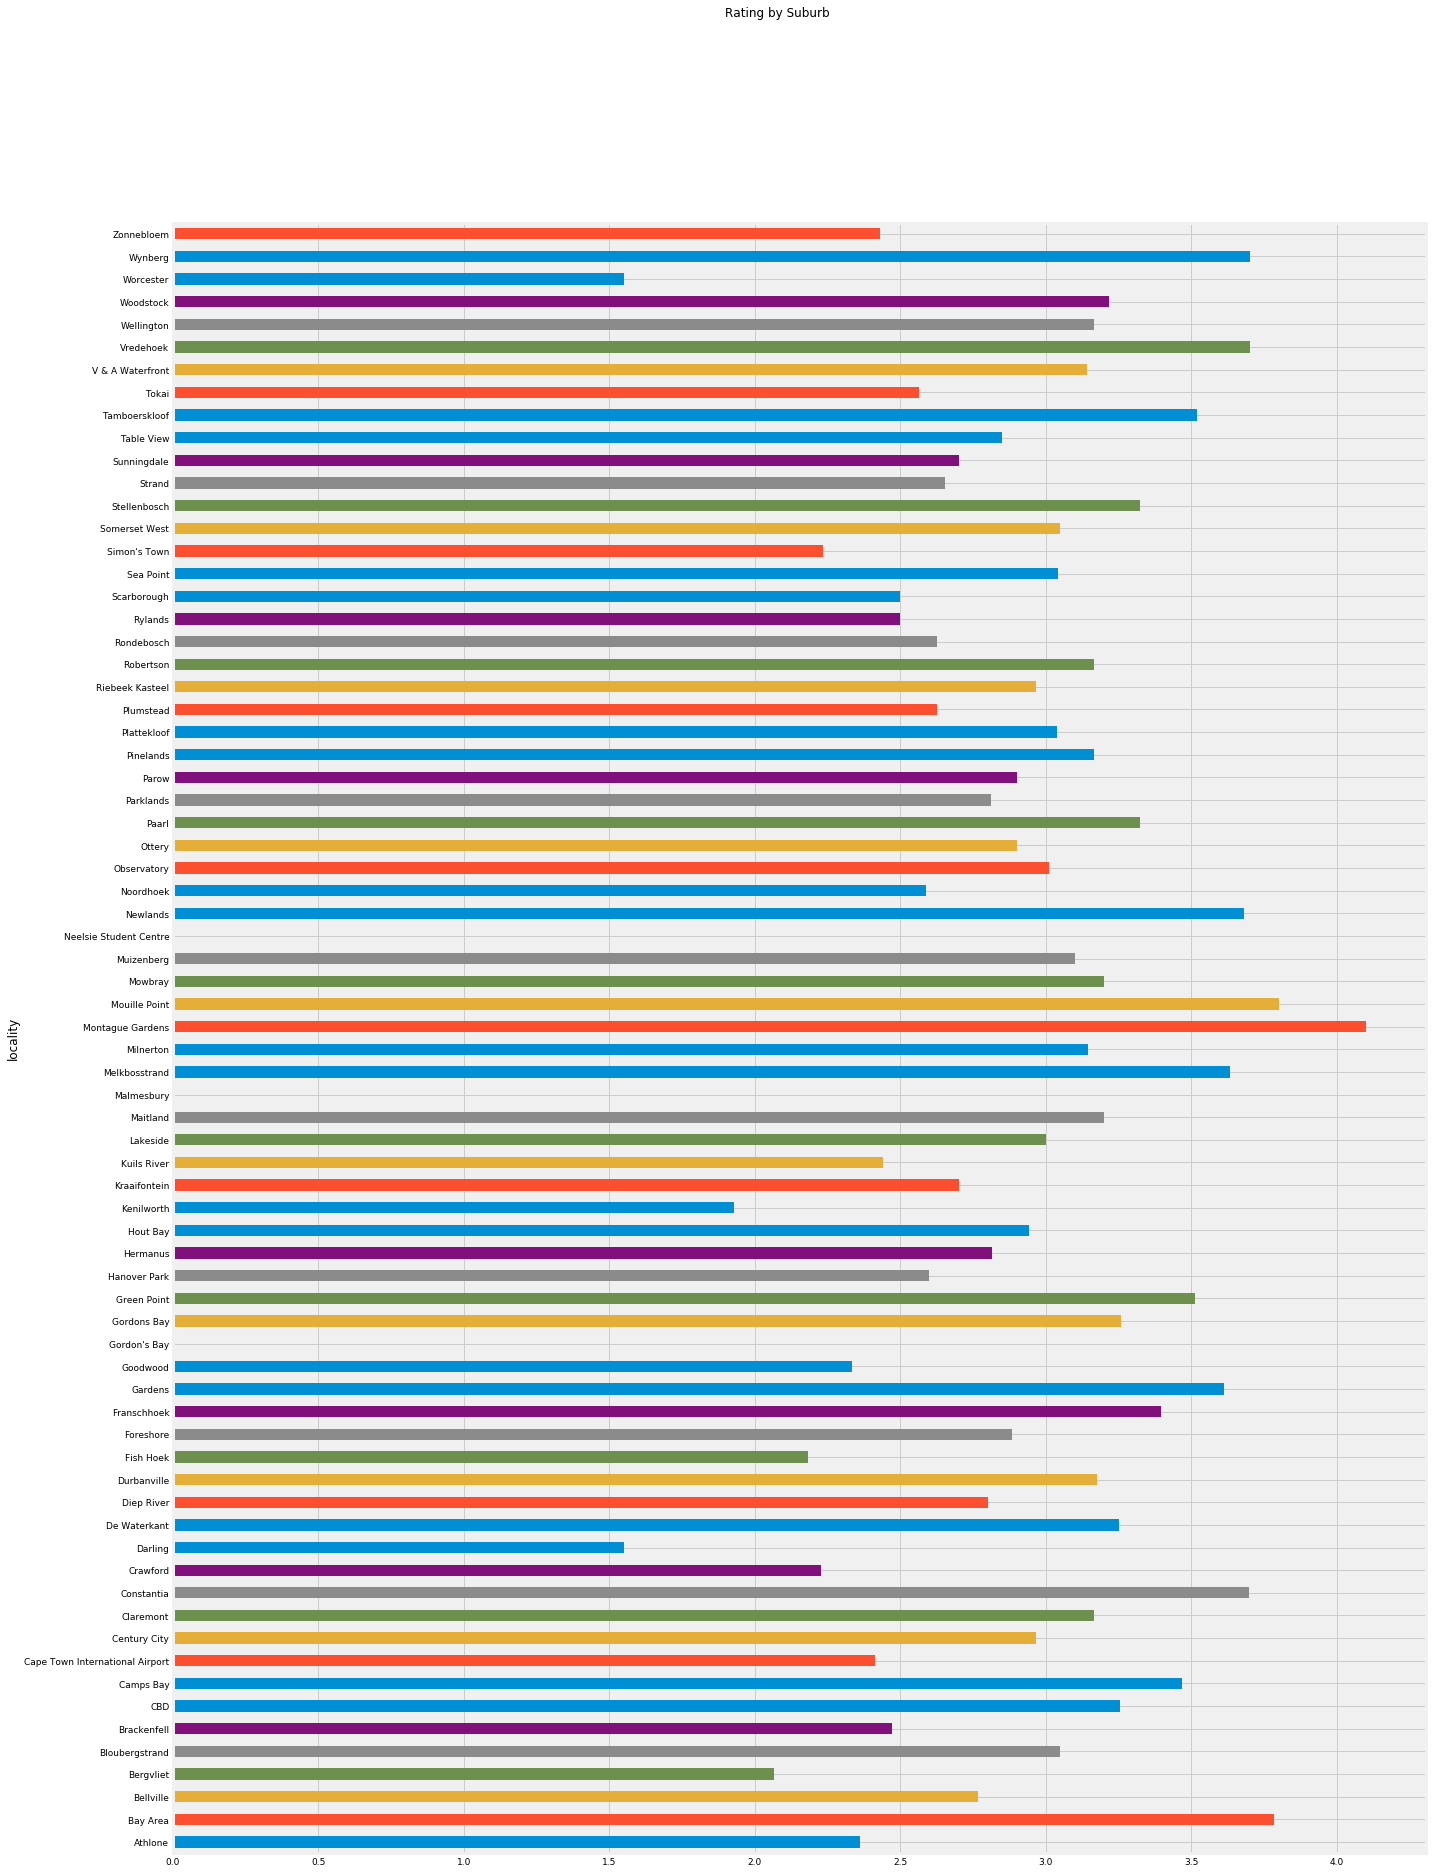

In [12]:
#cols = ["aggregate_rating"]
#xlabels = ["Avg. Rating"]
#fig = plt.figure(figsize=(20,20), dpi=400)
#fig.subplots_adjust(hspace=0.4)


df_suburb["aggregate_rating"].plot.barh(figsize=(20,30))
# ax.set_xlabel(xlabel)

# ax.set_ylabel("")
   
plt.suptitle("Rating by Suburb")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

In [ ]:
# 